<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-osdc2020/blob/master/01_04_exercise_1_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

In this exercise, we will construct a CNN model to classify images using the CIFAR-10 dataset.

We will try to improve the quality of the classification using some strategies we listed in the previous notebook.

* Increase number of layers.
* Try regularization
  * L1, L2, L1+L2
  * Dropout.
  * BatchNorm.
* Adjust optimizer learning rate.
* Try out other optimizers.
* Adjust batch size.

We will also look at a data oriented approach which can also often help with performance.

* Data augmentation

__NOTE__: if you haven't already done so, set your runtime to use GPU (Runtime :: Change Runtime Type :: GPU). You will need it for this exercise.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

## Common Utilities

In [2]:
def plot_training_curves(history):
  epochs = np.arange(len(history.history["loss"]))
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, history.history["loss"], label="training")
  plt.plot(epochs, history.history["val_loss"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(1, 2, 2)
  plt.plot(epochs, history.history["accuracy"], label="training")
  plt.plot(epochs, history.history["val_accuracy"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.tight_layout()
  _ = plt.show()


## Dataset

Dataset is available through `keras.datasets`. Each image is of size (32, 32, 3). Labels are 0-9 indicating one of 10 classes.

* Normalize the image pixel values to the 0-1 range.
* Convert the image matrix to float32.
* One-hot encode the labels.

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

170500096/170498071 [==============================] - 4s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

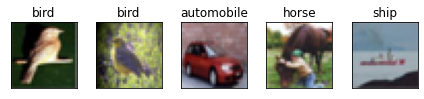

In [4]:
# from https://www.cs.toronto.edu/~kriz/cifar.html
id2label = {i:x for i, x in enumerate(
    ["airplane", "automobile", "bird", "cat", "deer",
     "dog", "frog", "horse", "ship", "truck"])}
image_ids = np.random.randint(0, high=Xtrain.shape[0], size=5)

for i, image_id in enumerate(image_ids):
  plt.subplot(1, 5, (i+1))
  plt.imshow(Xtrain[image_id])
  plt.title(id2label[ytrain[image_id][0]])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
_ = plt.show()

In [5]:
# TODO: cast the input tensors to float32
Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)

In [6]:
# TODO: convert pixels from 0-255 range to 0-1 range
Xtrain /= 255
Xtest /= 255

In [7]:
# TODO: one hot encode the labels
ytrain = keras.utils.to_categorical(ytrain, 10)
ytest = keras.utils.to_categorical(ytest, 10)

## Model 1 -- baseline

Build a CNN that will accept CIFAR-10 images and return a 10 way classification.

Your model should use a single convolution + pooling layer, and two Dense layers. The convolution layer should have 32 filters, each of size (3, 3). The pooling layer should be a max pooling layer with pool size (2, 2).

The number of hidden units in the first dense layer should be 512. The second dense layer is the output layer.

Since this is a n-way (n > 2) classification problem, use the categorical cross-entropy loss function. For this example, use the RMSProp optimizer, and accuracy as your metric.

Train your model for 5 epochs with a batch size of 128, using 20% of the training data for inline validation.

In [8]:
# TODO: define model as model_1
def conv_pool_layer(layer_id, num_filters, filter_size, 
                    pool_size, input_shape=None, 
                    use_batchnorm=False):
  model = keras.models.Sequential(name="conv_pool_{:d}".format(layer_id))
  if input_shape is not None:
    model.add(keras.layers.Conv2D(num_filters, kernel_size=filter_size,
                                  input_shape=input_shape))
  else:
    model.add(keras.layers.Conv2D(num_filters, kernel_size=filter_size))
  model.add(keras.layers.Activation("relu"))
  if use_batchnorm:
    model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size=pool_size))
  return model


model_1 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3686912   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [9]:
# TODO: compile model_1
model_1.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [10]:
# TODO: train model_1, save output of fit() into history_1
history_1 = model_1.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 1.7575 - accuracy: 0.4019 - val_loss: 1.5476 - val_accuracy: 0.4492
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 1.3083 - accuracy: 0.5458 - val_loss: 1.3418 - val_accuracy: 0.5363
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 1.1544 - accuracy: 0.5992 - val_loss: 1.1681 - val_accuracy: 0.5952
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 1.0302 - accuracy: 0.6422 - val_loss: 1.2432 - val_accuracy: 0.5838
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.9258 - accuracy: 0.6802 - val_loss: 1.1657 - val_accuracy: 0.6026


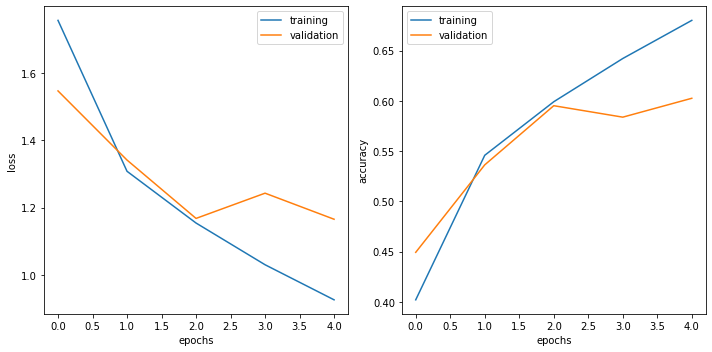

In [11]:
# TODO (optional): plot training plots for history_1 (or use Tensorboard)
plot_training_curves(history_1)

## Model 2 -- increase number of conv/pool layers

Modify the model you just created and add in 2 additional convolution + pooling layers, with 64 and 128 filters respectively, all other parameters remaining the same.

Call this model 2.

In [12]:
# TODO: define model as model_2
model_2 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  conv_pool_layer(1, 64, (3, 3), (2, 2)),
  conv_pool_layer(2, 128, (3, 3), (2, 2)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
conv_pool_1 (Sequential)     (None, 6, 6, 64)          18496     
_________________________________________________________________
conv_pool_2 (Sequential)     (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 361,034
Trainable params: 361,034
Non-trainable params: 0
________________________________________________

In [13]:
# TODO: compile model_2
model_2.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [14]:
# TODO: train model_2, save output of fit() into history_2
history_2 = model_2.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 1.7697 - accuracy: 0.3564 - val_loss: 1.5124 - val_accuracy: 0.4427
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 1.3752 - accuracy: 0.5142 - val_loss: 1.4061 - val_accuracy: 0.4866
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 1.1789 - accuracy: 0.5880 - val_loss: 1.1214 - val_accuracy: 0.5945
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 1.0372 - accuracy: 0.6386 - val_loss: 1.1178 - val_accuracy: 0.6041
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.9289 - accuracy: 0.6755 - val_loss: 0.9951 - val_accuracy: 0.6554


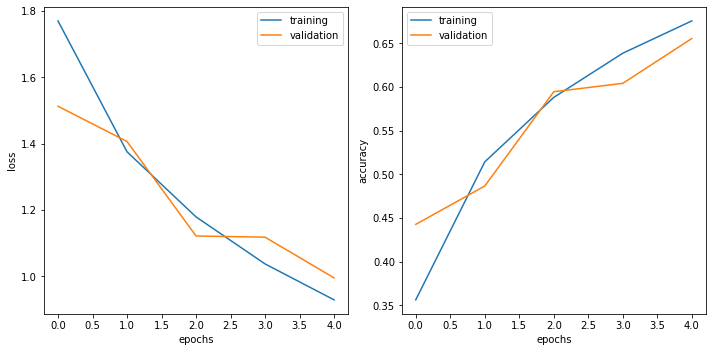

In [15]:
# TODO (optional): plot training plots for history_2 (or use Tensorboard)
plot_training_curves(history_2)

## Model 3: Dense layer regularization (L1, L2)

Modify the original model (`model_1`) to add weight regularization to the first Dense layer. Apply the following regularization:

* kerner_regularizer=`l1l2(l1=1e-5, l2=1e-4)`
* bias_regularizer=`l2(1e-4)`
* activity_regularizer=`l2(1e-5)`

In [16]:
# TODO: define model as model_3
model_3 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512,
      kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=keras.regularizers.l2(1e-4),
      activity_regularizer=keras.regularizers.l2(1e-5),
      activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               3686912   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [17]:
# TODO: compile model_3
model_3.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [18]:
# TODO: train model_3, save output of fit() into history_3
history_3 = model_3.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 3s 8ms/step - loss: 1.9207 - accuracy: 0.4006 - val_loss: 1.6280 - val_accuracy: 0.4966
Epoch 2/5
313/313 [==============================] - 2s 8ms/step - loss: 1.5819 - accuracy: 0.5145 - val_loss: 1.5747 - val_accuracy: 0.5147
Epoch 3/5
313/313 [==============================] - 2s 8ms/step - loss: 1.4780 - accuracy: 0.5555 - val_loss: 1.6409 - val_accuracy: 0.5240
Epoch 4/5
313/313 [==============================] - 2s 8ms/step - loss: 1.4060 - accuracy: 0.5864 - val_loss: 1.4760 - val_accuracy: 0.5664
Epoch 5/5
313/313 [==============================] - 2s 8ms/step - loss: 1.3508 - accuracy: 0.6144 - val_loss: 1.4278 - val_accuracy: 0.5877


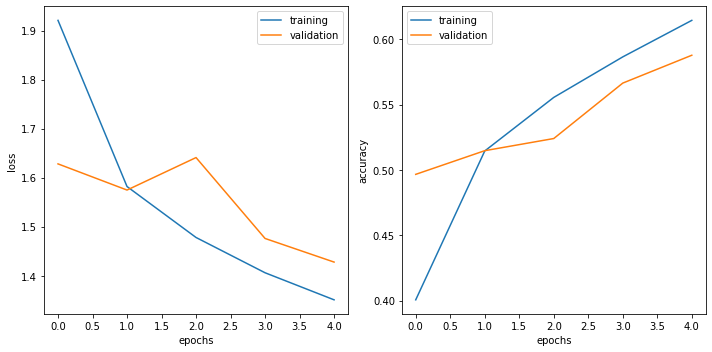

In [19]:
# TODO (optional): plot training plots for history_3 (or use Tensorboard)
plot_training_curves(history_3)

## Model 4: Add Dropout regularization

Modify `model_1` to add a `Dropout` layer between the two Dense layers in the network, such that during training, around 40% of the input neurons are dropped.

In [20]:
# TODO: define model as model_4
model_4 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(10, activation="softmax")
])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               3686912   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [21]:
# TODO: compile model_4
model_4.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [22]:
# TODO: train model_4, save output of fit() into history_4
history_4 = model_4.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 1.6672 - accuracy: 0.4096 - val_loss: 1.4175 - val_accuracy: 0.4979
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 1.3255 - accuracy: 0.5352 - val_loss: 1.2350 - val_accuracy: 0.5606
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 1.1808 - accuracy: 0.5842 - val_loss: 1.3570 - val_accuracy: 0.5196
Epoch 4/5
313/313 [==============================] - 2s 7ms/step - loss: 1.0741 - accuracy: 0.6240 - val_loss: 1.1853 - val_accuracy: 0.5824
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.9815 - accuracy: 0.6574 - val_loss: 1.0821 - val_accuracy: 0.6194


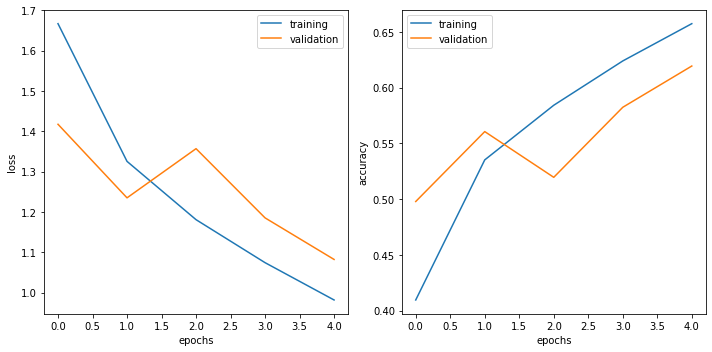

In [23]:
# TODO (optional): plot training plots for history_4 (or use Tensorboard)
plot_training_curves(history_4)

## Model 5: Add BatchNorm

Modify `model_1` to add a `BatchNorm` layer after the `Conv2D` layer. This ensures that the input is centered around mean 0 and has standard deviation 1.

In [24]:
# TODO: define model as model_5
model_5 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3), 
                  use_batchnorm=True),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        1024      
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               3686912   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 3,693,066
Trainable params: 3,693,002
Non-trainable params: 64
_________________________________________________________________


In [25]:
# TODO: compile model_5
model_5.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [26]:
# TODO: train model_5, save output of fit() into history_5
history_5 = model_5.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 8ms/step - loss: 1.4903 - accuracy: 0.5310 - val_loss: 1.7361 - val_accuracy: 0.4348
Epoch 2/5
313/313 [==============================] - 2s 7ms/step - loss: 0.8578 - accuracy: 0.7057 - val_loss: 1.2322 - val_accuracy: 0.5759
Epoch 3/5
313/313 [==============================] - 2s 7ms/step - loss: 0.5186 - accuracy: 0.8219 - val_loss: 1.8299 - val_accuracy: 0.5183
Epoch 4/5
313/313 [==============================] - 2s 7ms/step - loss: 0.2850 - accuracy: 0.9061 - val_loss: 1.8459 - val_accuracy: 0.5833
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.1597 - accuracy: 0.9501 - val_loss: 1.9273 - val_accuracy: 0.6369


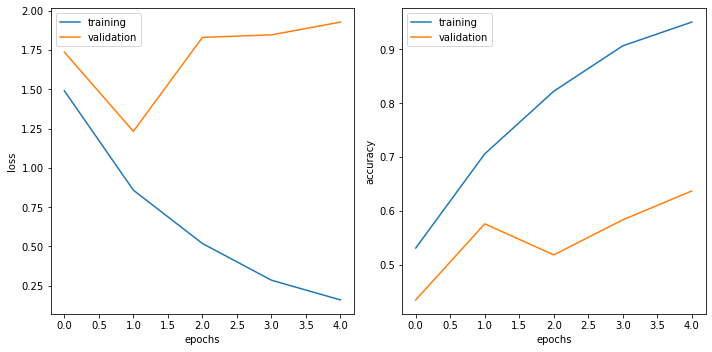

In [27]:
# TODO (optional): plot training plots for history_5 (or use Tensorboard)
plot_training_curves(history_5)

## Model 6: Adjust Learning Rate

Train the baseline model `model_1` using the `RMSProp` optimizer with `learning_rate` set to `5e-3`.

In [28]:
# TODO: define model as model_6
model_6 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               3686912   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [29]:
# TODO: compile model_6
optimizer = keras.optimizers.RMSprop(learning_rate=5e-3)
model_6.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [30]:
# TODO: train model_6, save output of fit() into history_6
history_6 = model_6.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 2.0794 - accuracy: 0.3600 - val_loss: 1.5388 - val_accuracy: 0.4682
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 1.3787 - accuracy: 0.5263 - val_loss: 1.3720 - val_accuracy: 0.5248
Epoch 3/5
313/313 [==============================] - 2s 7ms/step - loss: 1.1100 - accuracy: 0.6197 - val_loss: 1.3887 - val_accuracy: 0.5570
Epoch 4/5
313/313 [==============================] - 2s 7ms/step - loss: 0.8839 - accuracy: 0.6974 - val_loss: 1.5473 - val_accuracy: 0.5476
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.6719 - accuracy: 0.7716 - val_loss: 1.5249 - val_accuracy: 0.5900


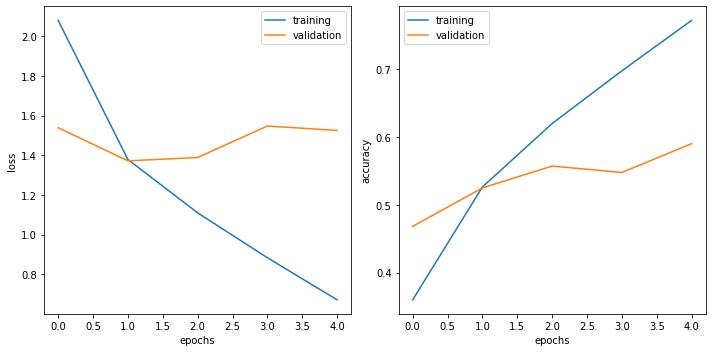

In [31]:
# TODO (optional): plot training plots for history_6 (or use Tensorboard)
plot_training_curves(history_6)

## Model 7: Choose a different optimizer

Switch out `RMSProp` with the `Adam` optimizer, with learning rate of `1e-3`.

In [32]:
# TODO: define model as model_7
model_7 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               3686912   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [33]:
# TODO: compile model_7
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_7.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [34]:
# TODO: train model_7, save output of fit() into history_7
history_7 = model_7.fit(Xtrain, ytrain, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 6ms/step - loss: 1.5857 - accuracy: 0.4376 - val_loss: 1.3342 - val_accuracy: 0.5294
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 1.2133 - accuracy: 0.5703 - val_loss: 1.1711 - val_accuracy: 0.5924
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 1.0784 - accuracy: 0.6220 - val_loss: 1.0730 - val_accuracy: 0.6308
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 0.9636 - accuracy: 0.6631 - val_loss: 1.0512 - val_accuracy: 0.6314
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.8710 - accuracy: 0.6986 - val_loss: 1.0248 - val_accuracy: 0.6445


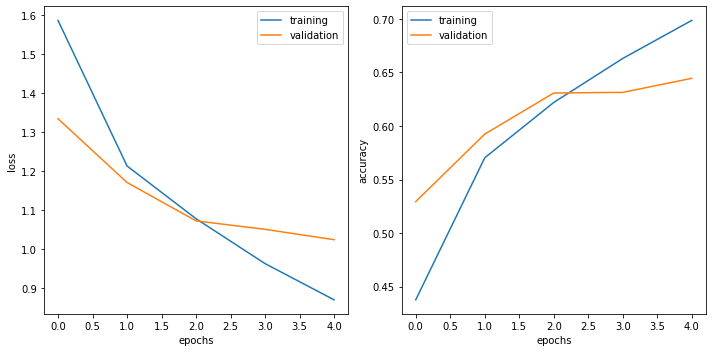

In [35]:
# TODO (optional): plot training plots for history_5 (or use Tensorboard)
plot_training_curves(history_7)

## Model 8: Change Batch Size

Retrain `model_1` using a smaller batch size of 64.

In [36]:
# TODO: define model as model_8
model_8 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               3686912   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [37]:
# TODO: compile model_8
model_8.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [38]:
# TODO: train model_8, save output of fit() into history_8
history_8 = model_8.fit(Xtrain, ytrain, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 3s 5ms/step - loss: 1.5064 - accuracy: 0.4645 - val_loss: 1.2522 - val_accuracy: 0.5632
Epoch 2/5
625/625 [==============================] - 3s 5ms/step - loss: 1.1526 - accuracy: 0.5958 - val_loss: 1.1157 - val_accuracy: 0.6151
Epoch 3/5
625/625 [==============================] - 3s 5ms/step - loss: 0.9715 - accuracy: 0.6605 - val_loss: 1.0406 - val_accuracy: 0.6408
Epoch 4/5
625/625 [==============================] - 3s 5ms/step - loss: 0.8178 - accuracy: 0.7165 - val_loss: 1.0581 - val_accuracy: 0.6476
Epoch 5/5
625/625 [==============================] - 3s 5ms/step - loss: 0.6699 - accuracy: 0.7689 - val_loss: 1.0940 - val_accuracy: 0.6453


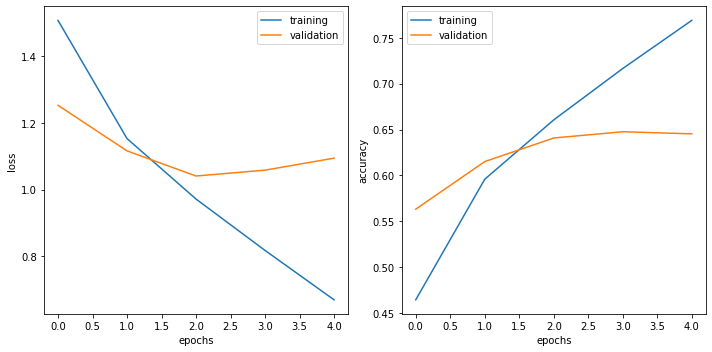

In [39]:
# TODO (optional): plot training plots for history_8 (or use Tensorboard)
plot_training_curves(history_8)

## Model 9: Data Augmentation

The intuition here is that the mirror image of a truck or a horse is just as much a truck or horse as the original. Same goes for if the image was viewed from a different angle. The Keras `ImageDataGenerator` provides many ways to transform the input into an infinite stream of slightly different images. 

Note that the transformations you allow it to do will depend on the application. For example, for many applications it wouldn't make sense to do vertical mirror images, although for some it might.

Next we want to augment our data. See the Keras documentation for [an example of how to use ImageDataGenerator](https://keras.io/api/preprocessing/image/).

In [40]:
# TODO: declare the ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [41]:
# TODO: define model as model_9
model_9 = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3)),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               3686912   
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 3,692,938
Trainable params: 3,692,938
Non-trainable params: 0
_________________________________________________________________


In [42]:
# TODO: compile model_9
model_9.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [43]:
# TODO: split the Xtrain and ytrain into 80/20 train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    Xtrain, ytrain, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [44]:
# TODO: fit model_9 using data generator
history_9 = model_9.fit(image_generator.flow(X_train, y_train, batch_size=128),
                        steps_per_epoch=X_train.shape[0] // 128, 
                        epochs=5, 
                        validation_data=(X_valid, y_valid))

Epoch 1/5
312/312 [==============================] - 20s 63ms/step - loss: 1.9046 - accuracy: 0.3301 - val_loss: 1.5381 - val_accuracy: 0.4719
Epoch 2/5
312/312 [==============================] - 20s 63ms/step - loss: 1.6183 - accuracy: 0.4215 - val_loss: 1.3727 - val_accuracy: 0.5224
Epoch 3/5
312/312 [==============================] - 20s 63ms/step - loss: 1.5302 - accuracy: 0.4519 - val_loss: 1.2711 - val_accuracy: 0.5531
Epoch 4/5
312/312 [==============================] - 20s 63ms/step - loss: 1.4661 - accuracy: 0.4760 - val_loss: 1.2496 - val_accuracy: 0.5498
Epoch 5/5
312/312 [==============================] - 20s 63ms/step - loss: 1.4125 - accuracy: 0.4955 - val_loss: 1.2546 - val_accuracy: 0.5550


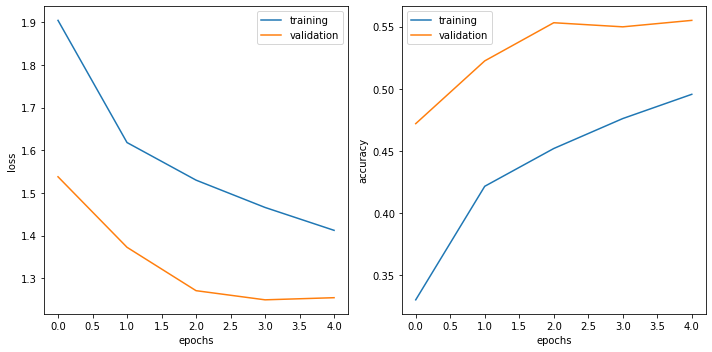

In [45]:
# TODO (optional): plot training plots for history_9 (or use Tensorboard)
plot_training_curves(history_9)

## Summary of Results

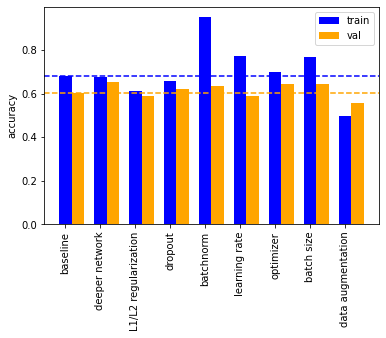

In [46]:
def plot_accuracies(methods, histories):
  train_accs, val_accs = [], []
  for method, history in zip(methods, histories):
    train_accs.append(history.history["accuracy"][-1])
    val_accs.append(history.history["val_accuracy"][-1])

  xs = np.arange(len(methods))
  width = 0.35
  plt.bar(xs, train_accs, width, color="b", label="train")
  plt.bar(xs+width, val_accs, width, color="orange", label="val")
  plt.axhline(y=train_accs[0], linestyle="--", color="b", xmin=0, xmax=1)
  plt.axhline(y=val_accs[0], linestyle="--", color="orange", xmin=0, xmax=1)
  plt.ylabel("accuracy")
  plt.xticks(xs, methods, rotation=90)
  plt.legend(loc="best")
  _ = plt.show()


methods = [
  "baseline",
  "deeper network",
  "L1/L2 regularization",
  "dropout",
  "batchnorm",
  "learning rate",
  "optimizer",
  "batch size",
  "data augmentation"
]
histories = [history_1, history_2, history_3,
             history_4, history_5, history_6,
             history_7, history_8, history_9]

plot_accuracies(methods, histories)

## Final model: combine features

Now combine features that have shown good results, and train for 20 epochs.

Finally evaluate the trained model against the test set and report test set accuracy.

In [48]:
# TODO: define model as model_f
def conv_pool_layer(layer_id, num_filters, filter_size, 
                    pool_size, input_shape=None, 
                    use_batchnorm=False):
  model = keras.models.Sequential(name="conv_pool_{:d}".format(layer_id))
  if input_shape is not None:
    model.add(keras.layers.Conv2D(num_filters, kernel_size=filter_size,
                                  input_shape=input_shape))
  else:
    model.add(keras.layers.Conv2D(num_filters, kernel_size=filter_size))
  model.add(keras.layers.Activation("relu"))
  if use_batchnorm:
    model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size=pool_size))
  return model


model_f = keras.models.Sequential([
  conv_pool_layer(0, 32, (3, 3), (2, 2), input_shape=(32, 32, 3),
                  use_batchnorm=True),
  conv_pool_layer(1, 64, (3, 3), (2, 2), use_batchnorm=True),
  conv_pool_layer(2, 128, (3, 3), (2, 2), use_batchnorm=True),
  keras.layers.Flatten(name="flatten"),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(10, activation="softmax")
])

model_f.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_0 (Sequential)     (None, 15, 15, 32)        1024      
_________________________________________________________________
conv_pool_1 (Sequential)     (None, 6, 6, 64)          18752     
_________________________________________________________________
conv_pool_2 (Sequential)     (None, 2, 2, 128)         74368     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

In [49]:
# TODO: compile model
model_f.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
# TODO: train model (20 epochs)
history_f = model_f.fit(Xtrain, ytrain, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 1.4432 - accuracy: 0.4918 - val_loss: 1.3020 - val_accuracy: 0.5204
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 1.0658 - accuracy: 0.6237 - val_loss: 1.0167 - val_accuracy: 0.6445
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.9067 - accuracy: 0.6808 - val_loss: 1.2678 - val_accuracy: 0.5901
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.7912 - accuracy: 0.7235 - val_loss: 0.9134 - val_accuracy: 0.6942
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.6931 - accuracy: 0.7556 - val_loss: 0.8826 - val_accuracy: 0.7014
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.6133 - accuracy: 0.7859 - val_loss: 0.9512 - val_accuracy: 0.6922
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.5406 - accuracy: 0.8087 - val_loss: 0.9657 - val_accuracy: 0.6993
Epoch 

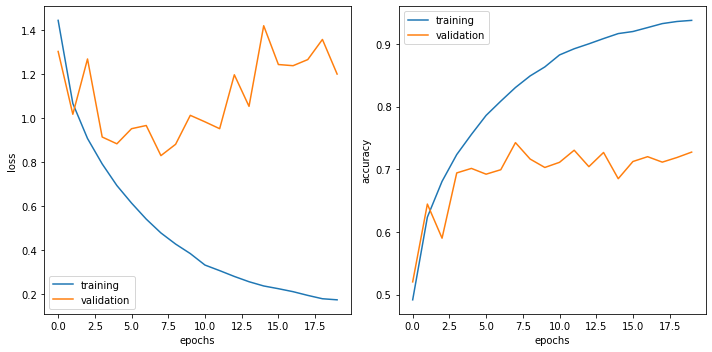

In [51]:
# TODO: plot training curves
plot_training_curves(history_f)

In [52]:
# TODO: evaluate against test set, report test accuracy
scores = model_f.evaluate(Xtest, ytest)
print("test loss: {:.5f}, test accuracy: {:.5f}".format(scores[0], scores[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.2342 - accuracy: 0.7237
test loss: 1.23420, test accuracy: 0.72370
